In [3]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from textblob import TextBlob

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.pipeline import make_pipeline

import pandas as pd
import numpy as np
import re  
import matplotlib.pyplot as plt

import pyLDAvis
import pyLDAvis.gensim_models

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Angela\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Angela\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
import pandas as pd
cerave = pd.read_csv("tweets_cerave.csv")
cerave = cerave.drop(['Unnamed: 0', 'Date', 'User'], axis=1)

## Data Cleaning

In [5]:
cerave.head()

,Tweet
0,CeraVe Eye Repair Cream | Under Eye Cream for ...
1,@IlluminateAest2 Thank you so much I am just s...
2,CeraVe SA Cleanser for $8!!\n\nhttps://t.co/Wd...
3,CeraVe SA Cleanser for $8!!\n\nhttps://t.co/IK...
4,CeraVe SA Cleanser for $8!\n\nhttps://t.co/o4x...


### Remove punctuation, special characters and lower casing

In [6]:
# 1 - Text cleaning
def clean_up(s):
    clean = re.sub(r'http\S+', '', s)
    return re.sub('[^A-Za-z ]+', ' ', clean).lower().strip()

def clean_up2(s):
    clean2 = re.sub(r'\W*\b\w{1,3}\b', '', s)
    return re.sub('[^A-Za-z ]+', ' ', clean2).lower().strip()

In [7]:
# In order to avoid errors, change type to string
cerave['Tweet'] = cerave['Tweet'].apply(str)  # change to string for avoiding errors

In [8]:
cerave['Tweet_Processed'] = cerave['Tweet'].apply(clean_up).apply(clean_up2)
cerave

,Tweet,Tweet_Processed
0,CeraVe Eye Repair Cream | Under Eye Cream for ...,cerave repair cream under cream dark circles...
1,@IlluminateAest2 Thank you so much I am just s...,illuminateaest thank much just seeing this us...
2,CeraVe SA Cleanser for $8!!\n\nhttps://t.co/Wd...,cerave cleanser
3,CeraVe SA Cleanser for $8!!\n\nhttps://t.co/IK...,cerave cleanser
4,CeraVe SA Cleanser for $8!\n\nhttps://t.co/o4x...,cerave cleanser
...,...,...
19995,@KendraWrites Me over here passing judgment wi...,kendrawrites over here passing judgment with s...
19996,@cerave Sure did! I am actually about to resto...,cerave sure actually about restock
19997,@ChefMimiSanchez We're so glad we could help y...,chefmimisanchez glad could help keep that heal...
19998,@MelanneyD We love it too!,melanneyd love


### Tokenize words and further clean-up text

In [9]:
import gensim
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data = cerave.Tweet_Processed.values.tolist()
data_words = list(sent_to_words(data))

print(data_words[:1][0][:30])

C:\Users\Angela\ANACONDA\lib\site-packages\botocore\httpsession.py:41: DeprecationWarning: 'urllib3.contrib.pyopenssl' module is deprecated and will be removed in a future release of urllib3 2.x. Read more in this issue: https://github.com/urllib3/urllib3/issues/2680
  from urllib3.contrib.pyopenssl import orig_util_SSLContext as SSLContext


['cerave', 'repair', 'cream', 'under', 'cream', 'dark', 'circles', 'puffiness', 'suitable', 'delicate', 'skin', 'under', 'area', 'ounce', 'this', 'link', 'yours']


### Phrase Modeling: Bigram and Trigram Models

In [10]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

### Remove Stopwords, Make Bigrams and Lemmatize

In [11]:
# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['SA', 'link', '$', 'ohmybeautybank'])

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Angela\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
#pip install spacy

In [13]:
!python -m spacy download en_core_web_sm
import spacy

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# print(data_lemmatized[:1][0][:30])

     --------------------------------------- 12.8/12.8 MB 14.2 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


C:\Users\Angela\ANACONDA\lib\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:18: DeprecationWarning: Call to deprecated create function FileDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  DESCRIPTOR = _descriptor.FileDescriptor(
C:\Users\Angela\ANACONDA\lib\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:36: DeprecationWarning: Call to deprecated create function FieldDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  _descriptor.FieldDescriptor(
C:\Users\Angela\ANACONDA\lib\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:43: DeprecationWarning: Call to deprecated create function FieldDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  _descriptor.F

In [14]:
data_words_bigrams

[['cerave',
  'repair',
  'cream',
  'cream',
  'dark_circles',
  'puffiness_suitable',
  'delicate',
  'skin',
  'area',
  'ounce'],
 ['illuminateaest',
  'thank',
  'much',
  'seeing',
  'used',
  'vaseline',
  'worked',
  'definitely',
  'going',
  'aquaphor',
  'happens',
  'think',
  'might',
  'toner',
  'started',
  'using',
  'cerave',
  'start',
  'feel',
  'itching',
  'maybe',
  'allergic'],
 ['cerave', 'cleanser'],
 ['cerave', 'cleanser'],
 ['cerave', 'cleanser'],
 ['cerave', 'cleanser'],
 ['cerave', 'cleanser'],
 ['cerave', 'actually'],
 ['pake', 'ordinary', 'moist', 'cerave', 'cocok'],
 ['saved', 'cerave', 'skincare'],
 ['love',
  'cerave',
  'healing_ointment',
  'thing',
  'helps',
  'eczema',
  'flare',
  'plus',
  'everything',
  'clean',
  'beauty',
  'exhausting'],
 ['cerave',
  'cleanser',
  'salicylic',
  'acid',
  'cleanser',
  'hyaluronic',
  'acid',
  'niacinamide',
  'ceramides',
  'exfol_ounce'],
 ['amazon',
  'deal_found',
  'cerave',
  'cleanser',
  'salicy

In [15]:
data_lemmatized

[['cream',
  'cream',
  'dark_circle',
  'puffiness_suitable',
  'delicate',
  'skin',
  'area',
  'ounce'],
 ['illuminatea',
  'thank',
  'much',
  'see',
  'used',
  'vaseline',
  'work',
  'definitely',
  'go',
  'aquaphor',
  'happen',
  'think',
  'toner',
  'start',
  'use',
  'cerave',
  'start',
  'feel',
  'itch',
  'maybe',
  'allergic'],
 ['cerave', 'cleanser'],
 ['cerave', 'cleanser'],
 ['cerave', 'cleanser'],
 ['cerave', 'cleanser'],
 ['cerave', 'cleanser'],
 ['actually'],
 ['pake', 'ordinary', 'moist'],
 ['save', 'skincare'],
 ['love',
  'healing_ointment',
  'thing',
  'help',
  'eczema',
  'clean',
  'beauty',
  'exhaust'],
 ['salicylic',
  'acid',
  'cleanser',
  'hyaluronic',
  'acid',
  'niacinamide',
  'ceramide'],
 ['deal_found',
  'cerave',
  'cleanser',
  'salicylic',
  'acid',
  'cleanser',
  'hyaluronic',
  'acid',
  'niacinamide',
  'ceramide',
  'exfoliant',
  'face',
  'fragrance',
  'free',
  'comedogenic',
  'ounce',
  'price',
  'deal',
  'amazon',
  'fre

### Data Transformation: Corpus and Dictionary

In [16]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

# It is creating a dictionary with the order of words and their frequency in the dataset
# For instance, if first word was able, it would indicate it appears 1 time in the dictionary

[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)]


### Base Model

In [17]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

### View the topics in LDA model

In [18]:
from pprint import pprint

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.177*"cleanser" + 0.175*"cerave" + 0.042*"hydrate" + 0.039*"foam" + '
  '0.038*"facial" + 0.026*"love" + 0.024*"thank" + 0.021*"give" + '
  '0.019*"cetaphil" + 0.012*"tell"'),
 (1,
  '0.065*"healing_ointment" + 0.052*"cerave" + 0.037*"night" + 0.032*"cream" + '
  '0.023*"morning" + 0.020*"apply" + 0.020*"time" + 0.019*"face" + '
  '0.016*"first" + 0.016*"beauty"'),
 (2,
  '0.039*"cerave" + 0.031*"break" + 0.029*"make" + 0.023*"soap" + 0.022*"ever" '
  '+ 0.022*"right" + 0.020*"amazing" + 0.020*"switch" + 0.018*"help" + '
  '0.018*"sure"'),
 (3,
  '0.083*"cerave" + 0.042*"well" + 0.042*"really" + 0.041*"work" + '
  '0.028*"think" + 0.027*"need" + 0.024*"feel" + 0.023*"skin" + '
  '0.023*"product" + 0.020*"people"'),
 (4,
  '0.096*"face" + 0.069*"wash" + 0.063*"cream" + 0.063*"lotion" + '
  '0.051*"cerave" + 0.038*"skin" + 0.037*"cleanser" + 0.036*"body" + '
  '0.036*"facial" + 0.035*"free"'),
 (5,
  '0.082*"cerave" + 0.072*"product" + 0.071*"good" + 0.052*"skincare" + '
  '0.02

### Compute Model Perplexity and Coherence Score

In [19]:
from gensim.models import CoherenceModel

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.47694589905562684


### Hyperparameter Tuning

In [18]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [19]:
coherence_model_lda

In [20]:
import numpy as np
import tqdm

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]

corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results_cerave.csv', index=False)
    pbar.close()

100%|██████████| 540/540 [7:21:03<00:00, 49.01s/it]  


In [20]:
result = pd.read_csv("lda_tuning_results_cerave.csv")
result

,Validation_Set,Topics,Alpha,Beta,Coherence
0,75% Corpus,2,0.01,0.01,0.577237
1,75% Corpus,2,0.01,0.31,0.564715
2,75% Corpus,2,0.01,0.61,0.563038
3,75% Corpus,2,0.01,0.9099999999999999,0.556317
4,75% Corpus,2,0.01,symmetric,0.569436
...,...,...,...,...,...
535,100% Corpus,10,asymmetric,0.01,0.489803
536,100% Corpus,10,asymmetric,0.31,0.518468
537,100% Corpus,10,asymmetric,0.61,0.526371
538,100% Corpus,10,asymmetric,0.9099999999999999,0.508813


In [21]:
#calculate mean of points grouped by topics -- REVISAR
topics = result.groupby('Topics')['Coherence'].mean()
topics

Topics
2     0.588239
3     0.551168
4     0.560033
5     0.511075
6     0.499984
7     0.500033
8     0.493838
9     0.471388
10    0.479211
Name: Coherence, dtype: float64

In [22]:
# Generated by OPEN AI 
import pandas as pd

coherence_values = {
    2: 0.588140,
    3: 0.551977,
    4: 0.560129,
    5: 0.512822,
    6: 0.503560,
    7: 0.497393,
    8: 0.491514,
    9: 0.472125,
    10: 0.480051
}

df = pd.DataFrame(list(coherence_values.items()), columns=['Topic', 'Coherence'])

In [23]:
df

,Topic,Coherence
0,2,0.588140
1,3,0.551977
2,4,0.560129
3,5,0.512822
4,6,0.503560
5,7,0.497393
6,8,0.491514
7,9,0.472125
8,10,0.480051


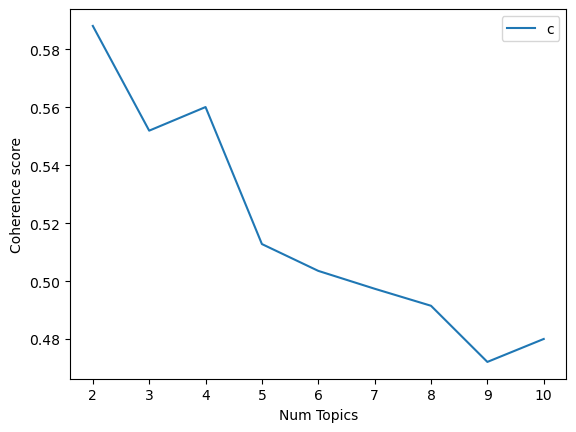

In [24]:
# Show graph -- fix it!
limit=40; start=2; step=6;
x = df['Topic']
y = df['Coherence']
plt.plot(x, y)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

## Final Model

In [25]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=2, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto')

In [26]:
import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds = "mmds", R=30)
vis

C:\Users\Angela\ANACONDA\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.067118  0.211873       1        1  59.105515
1      0.067118 -0.211873       2        1  40.894485, topic_info=            Term         Freq         Total Category  logprob  loglift
27      cleanser  4242.000000   4242.000000  Default  30.0000  30.0000
52          face  3485.000000   3485.000000  Default  29.0000  29.0000
1          cream  2339.000000   2339.000000  Default  28.0000  28.0000
58        lotion  2313.000000   2313.000000  Default  27.0000  27.0000
109         wash  2185.000000   2185.000000  Default  26.0000  26.0000
..           ...          ...           ...      ...      ...      ...
80         night   512.847643    673.117128   Topic2  -4.8310   0.6222
93   moisturizer   841.749046   1378.544353   Topic2  -4.3355   0.4009
9         cerave  3234.541556  10310.952858   Topic2  -2.9894  -0.2651
141         type   420.043730    561.807601   Topic2  -5.0307   0.6034
68          acne   412.843176    602.308821   Topic2  -5.0479   0.5165

[108 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
42        1  0.000641  acid
42        2  0.999853  acid
68        1  0.313793  acne
68        2  0.685695  acne
77        1  0.998680  also
...     ...       ...   ...
109       2  0.999911  wash
370       1  0.999572  well
370       2  0.001229  well
26        1  0.999377  work
26        2  0.001064  work

[150 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [28]:
pyLDAvis.save_html(vis, 'lda_visualization_cerave.html')